# Пригодность воды для питья.

## Введение и информация об данных.

В данном ноутбуке проведена работа по обучению моделей-классификаторов с целью предсказания фактора пригодности воды в употребление. Данные были взяты из открытого датасета на сайте **Kaggle**.

Ссылка на датасет -> https://www.kaggle.com/adityakadiwal/water-potability

Самый лучший результат, что я заметил был **69,5%**

**Информация об данных:**
 * **ph** - водородный показатель
 * **Hardness** - жесткость воды(количество содержащихся минералов в мг/л)
 * **Solids** - общее количество растворенных твердых веществ в частях на миллионую долю
 * **Chloramines** - общее количество хлораминов на миллионую долю
 * **Sulfate** - количество растворенных сульфатов в мг/л
 * **Conductivity** - электропроводность воды в мкСм/см
 * **Organic_carbon** - количество органического углерода на миллионую долю
 * **Trihalomethanes** - количество тригалометанов в мкг/л
 * **Turbidity** - измерение светоизлучающей способности воды в НЕМ(нефелометрических единицах мутности)
 * **Potability** - указывает, безопасна ли вода для потребления человеком

## Импорт библиотек и загрузка данных.

In [1]:
'''
Импорт библиотек.
'''
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix, roc_curve, auc

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
sns.set(rc={'figure.figsize': (10,6)})

In [2]:
'''
Загрузка данных.
'''
df = pd.read_csv('water_potability.csv')
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## Осмотр данных.

Прежде чем приступить к созданию и обучению моделей, я бы хотел посмотреть на качество данных.

In [3]:
# Описательная статистика.
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [4]:
# Тип данных.
df.dtypes

ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object

In [5]:
# Количество пропущенных значений.
df.isna().sum()

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

In [6]:
# Общее кол-во записей.
print(f'Всего записей - {df.shape[0]}')

Всего записей - 3276


Посмотрим на распределение данных в колонках с пропущенными значениями.

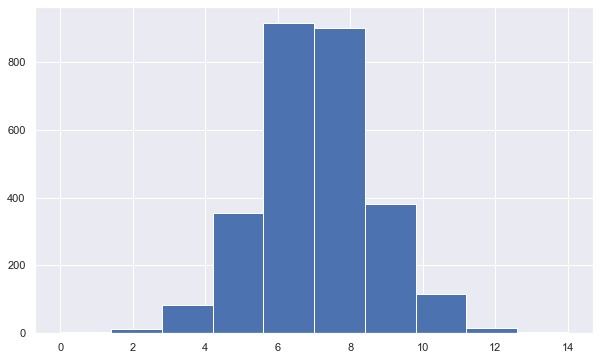

In [7]:
# Водородный показатель.
df['ph'].hist()
plt.show()

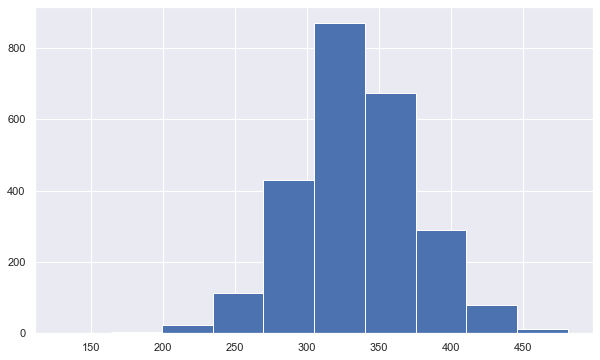

In [8]:
# Количество растворенных сульфатов в мг/л.
df['Sulfate'].hist()
plt.show()

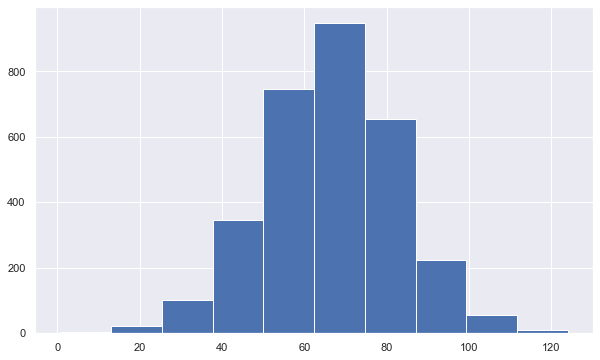

In [9]:
# Количество тригалометанов в мкг/л
df['Trihalomethanes'].hist()
plt.show()

## Null-значения.

Для обучения моделей в нашем датасете должны отсутствовать null-значения. Удалять данные будет не лучшим решением, т.к мы решимся большой доли наблюдений, будет логичным **заполнить** пропущенные значения. У нас имеется 2 варианта:

 * Заполнить средним значением.
 * Обучить отдельную модель, которая будет предсказывать значение столбца(вариант для тех, кто совсем отчаялся).
 
Заполнить пропуски средним значением выглядит довольно неплохим решением, при условие, что наши данные имеют **нормальное распределение.**

Исходя из гистограмм для каждой переменной, мы видим, что они **стремятся** к нужному нам распределению, но будет лучше если мы проверим это с помощью критерия **Шапиро-Уилка**.

**H0** *- данные имеют нормальное распределение.*

**H1** *- данные НЕ имеют нормальное распределение.*

In [10]:
ph_sample = df['ph'].dropna().sample(50)
_, p_value = shapiro(ph_sample)
print(f'p-уровень значимости = {np.round(p_value, 3)}')

p-уровень значимости = 0.628


In [11]:
sulfate_sample = df['Sulfate'].dropna().sample(50)
_, p_value = shapiro(sulfate_sample)
print(f'p-уровень значимости = {np.round(p_value, 3)}')

p-уровень значимости = 0.119


In [12]:
trihalomethanes_sample = df['Trihalomethanes'].dropna().sample(50)
_, p_value = shapiro(trihalomethanes_sample)
print(f'p-уровень значимости = {np.round(p_value, 3)}')

p-уровень значимости = 0.056


Во всех трёх случаях у нас **достаточно** оснований предполагать, что данные в колонках распределены нормально. Поэтому пропущенные значения заполним средним.

In [13]:
'''
Заполнение пропущенных значений.
'''
values_dict = {
    'ph': df['ph'].mean(),
    'Sulfate': df['Sulfate'].mean(),
    'Trihalomethanes': df['Trihalomethanes'].mean()
}

df.fillna(value=values_dict, axis=0, inplace=True)

In [14]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,333.775777,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,333.775777,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [15]:
df.isna().sum()

ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64

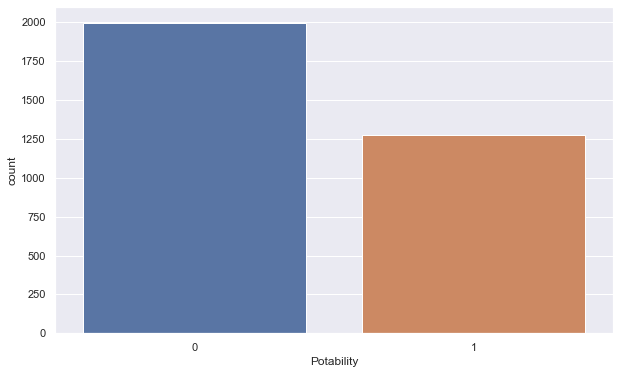

In [16]:
# Соотношений значений в целевой переменной-классификации.
sns.countplot(data = df, x = "Potability")
plt.show()

## Взаимосвязь переменных.

Посмотрим на то, как переменные влияют друг на друга.

<AxesSubplot:>

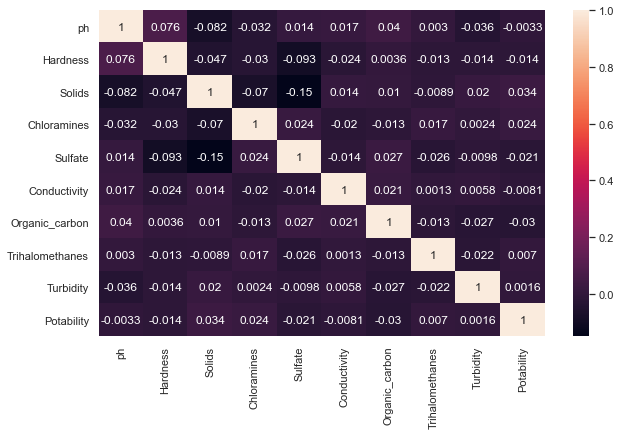

In [17]:
sns.heatmap(df.corr(), annot=True)

Сильной зависимости между переменными не наблюдается.

Можно приступить к обучению моделей.

## Модели машинного обучения.

### Подготовка данных.

In [18]:
X = df[df.columns[:-1]]
Y = df['Potability']
X.head(1)

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
0,7.080795,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.99097,2.963135


In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)

In [20]:
models = list()
accuracies = list()
recalls = list()
precisions = list()
f1_scores = list()

def append_values_to_lists(estimator, model_name):
    '''
    Добавляет результаты моделей в созданные ранее списки.
    
    Параметры:
    
    estimator - модель машинного обучения.
    model_name - название модели.
    '''
    models.append(model_name)
    accuracies.append(np.round(estimator.score(X_test, Y_test), 2))
    
    if model_name == 'Logistic Regression':
        recalls.append(None)
        precisions.append(None)
        f1_scores.append(None)
    else:
        recalls.append(np.round(recall_score(Y_test, estimator.predict(X_test)), 2))
        precisions.append(np.round(precision_score(Y_test, estimator.predict(X_test)), 2))
        f1_scores.append(np.round(f1_score(Y_test, estimator.predict(X_test)), 2))

def plot_confusion_matrix(estimator, model_name):
    '''
    Строит матрицу ошибок.
    
    Параметры:
    
    estimator - модель машинного обучения.
    model_name - название модели.
    '''
    
    sns.heatmap(confusion_matrix(Y_test, estimator.predict(X_test)), annot=True)
    plt.title(f'{model_name} - Матрица Ошибок', fontsize=16)
    plt.show()
    

def plot_feature_importances(estimator, model_name):
    '''
    Строит гистограмму важности переменных.
    
    Параметры:
    
    estimator - модель машинного обучения.
    model_name - название модели.
    '''
    
    if model_name == 'Logistic Regression':
        imp = pd.DataFrame(estimator.coef_[0], index=X.columns, columns=['Potability'])
    else:
        imp = pd.DataFrame(estimator.feature_importances_, index=X.columns, columns=['Potability'])
    
    imp.sort_values('Potability').plot(kind='barh', figsize=(12, 8))
    plt.title(f'{model_name} - Важность переменых', fontsize=16)
    plt.show()

### Random Forest

In [21]:
# Создадим набор параметров.
random_forest_params = {
    'n_estimators': range(1, 10),
    'max_features': range(2, 9),
    'criterion': ['gini', 'entropy'],
    'max_depth': range(1, 10),
    'min_samples_split': range(5, 20, 5)
}

# Кросс-валидация.
random_forest_grid_search_cv = GridSearchCV(RandomForestClassifier(),
                                            random_forest_params,
                                            cv=5,
                                            n_jobs=1
                                           ).fit(X_train, Y_train)

# Получим модель с лучшими параметрами.
random_forest = random_forest_grid_search_cv.best_estimator_

'''
Запишем результаты модели.
'''
append_values_to_lists(random_forest, 'Random Forest')

# Вывод лучших параметров.
random_forest_grid_search_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_features': 7,
 'min_samples_split': 10,
 'n_estimators': 9}

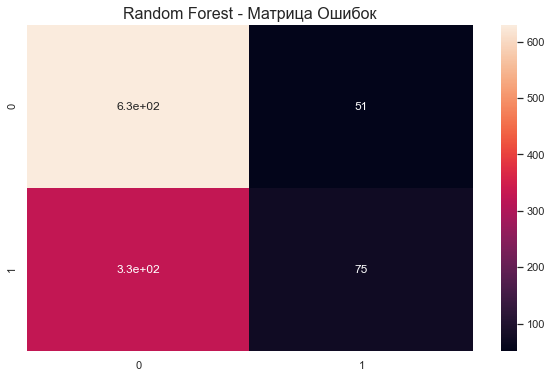

In [22]:
plot_confusion_matrix(random_forest, 'Random Forest')

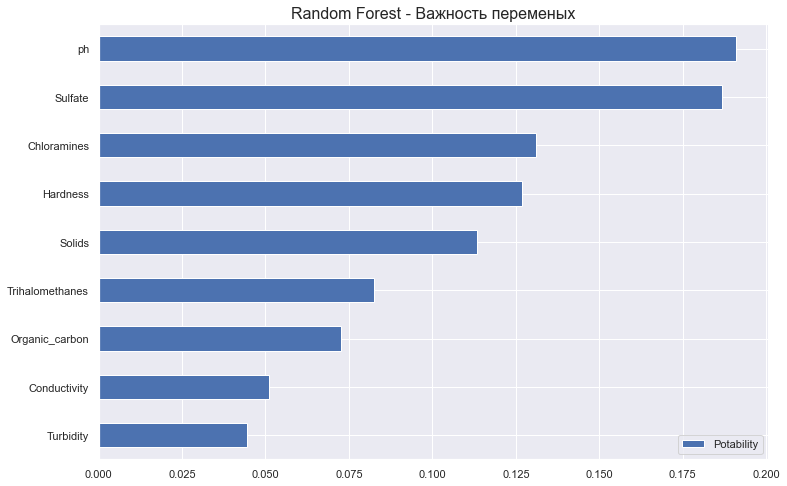

In [23]:
plot_feature_importances(random_forest, 'Random Forest')

### LogisticRegression

In [24]:
log_regression = LogisticRegression().fit(X_train, Y_train)
append_values_to_lists(log_regression, 'Logistic Regression')

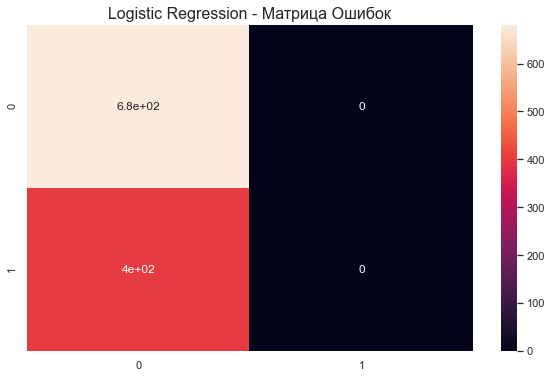

In [25]:
plot_confusion_matrix(log_regression, 'Logistic Regression')

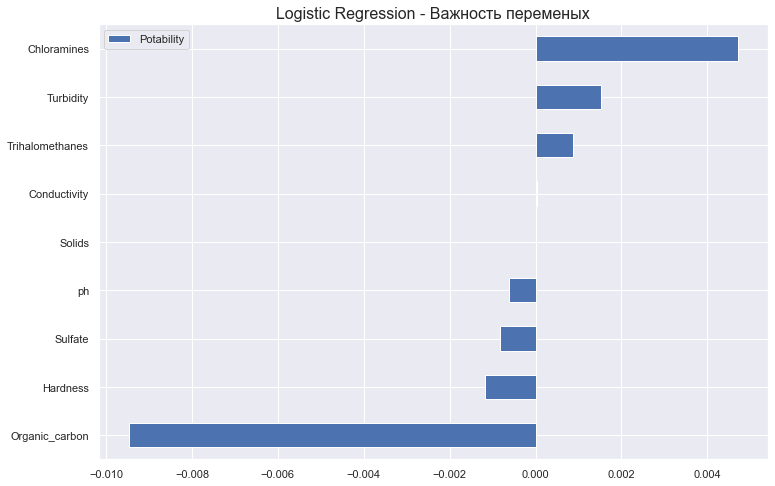

In [26]:
# Важность переменных.
plot_feature_importances(log_regression, 'Logistic Regression')

### KNeighborsClassifier

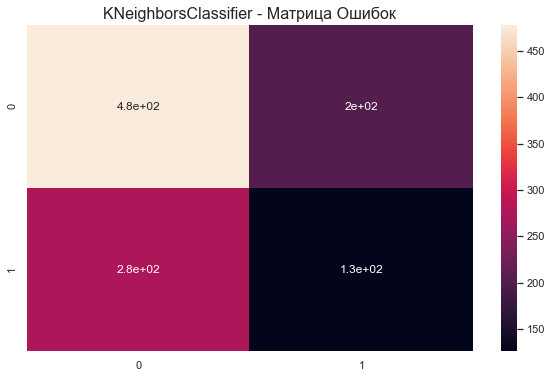

In [27]:
knc = KNeighborsClassifier().fit(X_train, Y_train)
append_values_to_lists(knc, 'KNeighborsClassifier')
plot_confusion_matrix(knc, 'KNeighborsClassifier')

### DecisionTree

In [28]:
decision_tree_params = {
    'max_depth': range(1, 30),
    'criterion': ['gini', 'entropy']
}
decision_tree_grid_search_cv = GridSearchCV(DecisionTreeClassifier(),
                                            decision_tree_params,
                                            cv=5, n_jobs=1).fit(X_train, Y_train)


decision_tree = decision_tree_grid_search_cv.best_estimator_
append_values_to_lists(decision_tree, 'Decision Tree')

decision_tree_grid_search_cv.best_params_

{'criterion': 'entropy', 'max_depth': 12}

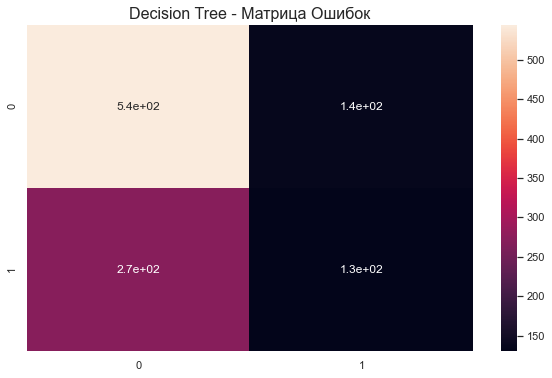

In [29]:
plot_confusion_matrix(decision_tree, 'Decision Tree')

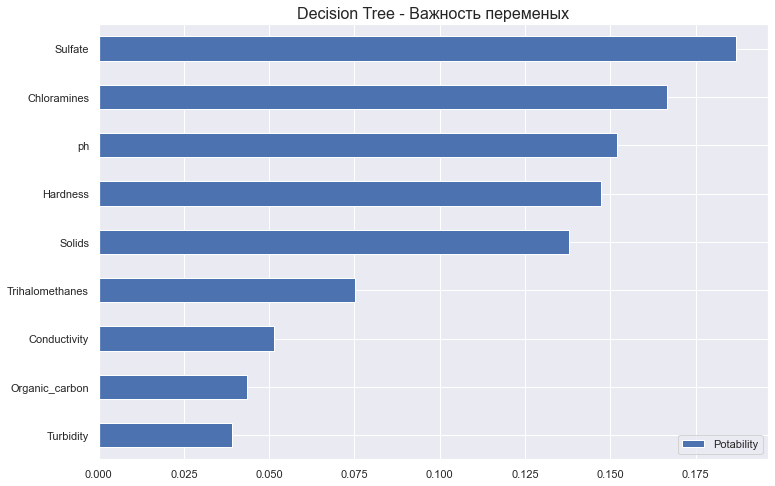

In [30]:
plot_feature_importances(decision_tree, 'Decision Tree')

### GradientBoost

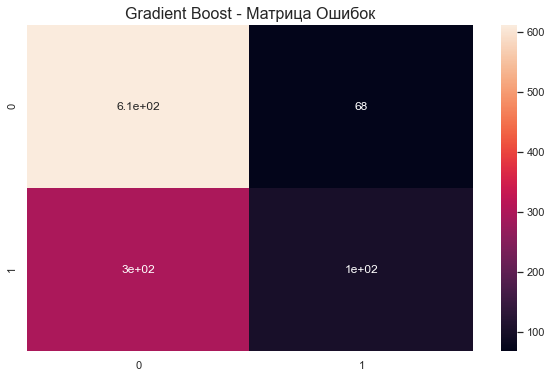

In [31]:
gradinet_boost = GradientBoostingClassifier().fit(X_train, Y_train)
append_values_to_lists(gradinet_boost, 'Gradient Boost')
plot_confusion_matrix(gradinet_boost, 'Gradient Boost')

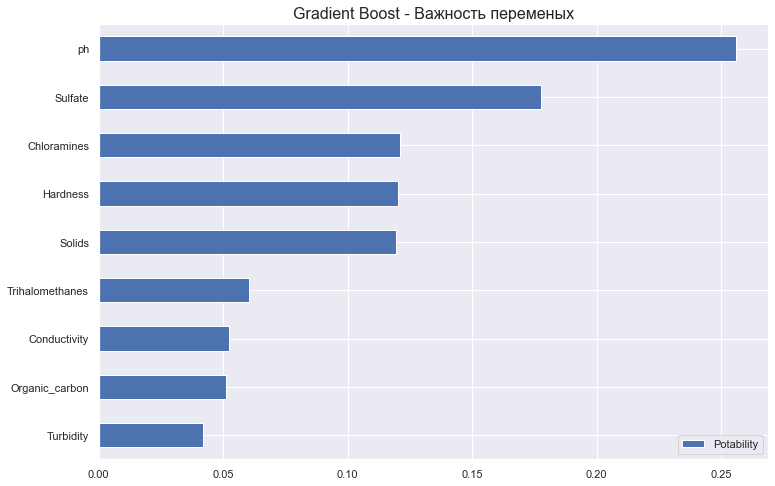

In [32]:
plot_feature_importances(gradinet_boost, 'Gradient Boost')

### Результаты моделей.

In [33]:
score_data = {
    'model': models,
    'accuracy': accuracies,
    'recall': recalls,
    'precision': precisions,
    'f1': f1_scores
}
df_scores = pd.DataFrame(data=score_data)

In [34]:
df_scores

,model,accuracy,recall,precision,f1
0,Random Forest,0.65,0.19,0.60,0.28
1,Logistic Regression,0.63,NaN,NaN,NaN
2,KNeighborsClassifier,0.56,0.31,0.38,0.35
3,Decision Tree,0.62,0.32,0.49,0.39
4,Gradient Boost,0.66,0.26,0.60,0.36


## ROC-кривые.

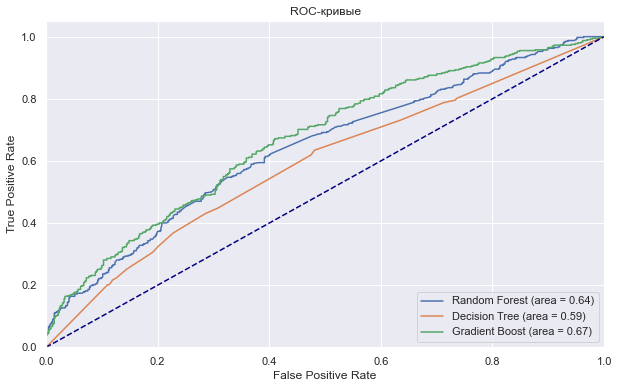

In [35]:
probs = [
    random_forest.predict_proba(X_test)[:, 1],
    decision_tree.predict_proba(X_test)[:, 1],
    gradinet_boost.predict_proba(X_test)[:, 1]
]

models_title = ('Random Forest', 'Decision Tree', 'Gradient Boost')

for i in range(len(models_title)):
    fpr, tpr, thresholds = roc_curve(Y_test,  probs[i])
    roc_auc= auc(fpr, tpr)
    plt.plot(fpr, tpr,
              label=f'{models_title[i]} (area = %0.2f)' % roc_auc)


plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые')
plt.legend(loc="lower right")
plt.show()

Лучше всего себя показали следующие модели:

* **Random Forest**
* **Gradient Boost**
* **Logistic Regression**
    
Можно перейти к тюнингу моделей и посмотреть как поменяется результат их работы.

## Тюнинг моделей.

### Random Forest.

**Памятка**: 


{'criterion': 'gini',
 'max_depth': 7,
 'max_features': 9,
 'min_samples_split': 10,
 'n_estimators': 7}

In [39]:
params = {
    'criterion': ['gini'],
    'max_depth': range(1, 10),
    'max_features': [2, 4, 6, 7, 8, 9],
    'min_samples_split': range(2, 10),
    'n_estimators': [7]
}

random_forest_grid_search_cv = GridSearchCV(RandomForestClassifier(), params, cv=5, n_jobs=1).fit(X_train, Y_train)
random_forest = random_forest_grid_search_cv.best_estimator_

print(random_forest_grid_search_cv.best_estimator_)
df_scores['accuracy'][1] < np.round(random_forest.score(X_test, Y_test), 2)

RandomForestClassifier(max_depth=7, max_features=9, min_samples_split=5,
                       n_estimators=7)


True

In [40]:
np.round(random_forest.score(X_test, Y_test), 2)

0.66

### LogisticRegression.

In [37]:
log_regression = LogisticRegression().fit(X_train[['Chloramines', 'Organic_carbon']], Y_train)
log_score_new = log_regression.score(X_test[['Chloramines', 'Organic_carbon']], Y_test)
df_scores['accuracy'][1] < log_score_new

False

### Итог тюнинга

Как таковой тюнинг моделей помог несильно.